In [1]:
import os
import numpy as np
os.getcwd()
import tensorflow as tf    
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
% matplotlib inline
import matplotlib

tf.reset_default_graph()

In [2]:
root_path = os.getcwd()
flowers_path = os.path.join(root_path, "flower_photos")

In [3]:
flower_classes = sorted([dirname for dirname in os.listdir(flowers_path)
                  if os.path.isdir(os.path.join(flowers_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [4]:
# Following Geron, we list all the image file paths, and sort them.
from collections import defaultdict
image_paths = defaultdict(list)

for flower_class in flower_classes:
    root_image_path = os.path.join(flowers_path, flower_class)
    for filepath in os.listdir(root_image_path):
        if filepath.endswith("jpg"):
            image_paths[flower_class].append(os.path.join(root_image_path, filepath))


In [ ]:
for paths in image_paths.values():
    paths.sort()

In [5]:
# To plot image files, get matplotlib.image
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#for flower_class in flower_classes:


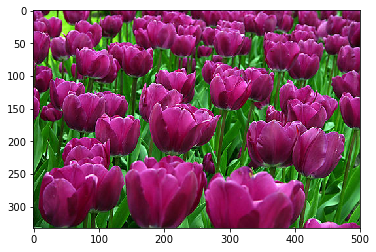

In [6]:
oneplot = mpimg.imread(image_paths['tulips'][25])
plt.imshow(oneplot)
#plt.axis('off')

In [7]:
# Since the image sizes are totally random, we need to crop all images to 299 X 299 and add random filters/flips to
# augment the dataset.
import numpy as np
from scipy.misc import imresize 
from scipy import ndimage

def data_crop_and_aug(input_img, target_height = int(299), target_width = int(299)):
    height = input_img.shape[0]
    width = input_img.shape[1]
    aspect = height/width
    target_aspect = 1
    
    crop_vertically = aspect > target_aspect
    crop_width = width if crop_vertically else height
    crop_height = height if crop_vertically == False else width
    
    # shrink box by random factor
    random_scale = 0.2*np.random.rand() + 1.0
    crop_width = crop_width/random_scale
    crop_height = crop_height/random_scale
    
    # now make new image
    x0 = np.random.randint(0, width-crop_width)
    y0 = np.random.randint(0, height-crop_height)
    x1 = x0 + int(crop_width)
    y1 = y0 + int(crop_height)
                  
    image = input_img[y0:y1, x0:x1]
    
    if np.random.rand() <0.5:
        image = np.fliplr(image)
    
    #if np.random.rand()<0.5:
    #  image = ndimage.rotate(image, 45)
    
    #if np.random.rand()<0.25:
    #    image = ndimage.gaussian_filter(image, sigma=1)

    image = imresize(image, (target_width, target_height))
    
    # Normalize the image
    return image.astype(np.float32)/np.float(255)

(-0.5, 298.5, 298.5, -0.5)

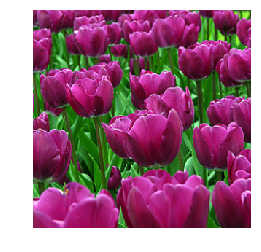

In [8]:
mod_plot = data_crop_and_aug(oneplot)
plt.imshow(mod_plot)
plt.axis('off')

In [9]:
# Fetch pretrained inception and freeze all but last layer and modify for flowers.
width = 299
height = 299
channels = 3

from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape = [None, height, width, channels], name = "X")
training = tf.placeholder_with_default(False, shape = [], name = 'training')
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes = 1001, is_training = training)
# is training makes sure training is true. -- make sure to set this.
inception_saver = tf.train.Saver()


In [ ]:
logits.op.inputs[0].op.inputs[0].op.inputs[0] # is the dropout layer right before the last layer.

In [10]:
prelogits = tf.squeeze(end_points["PreLogits"], axis = [1, 2])

In [11]:
n_outputs = len(flower_classes)

flower_logits = tf.layers.dense(prelogits, n_outputs, name = "flower_logits")
y_proba = tf.nn.softmax(flower_logits, name = "Y_proba")

# Next we freeze all other layers and only train the output layer. 
y = tf.placeholder(tf.int32, shape = [None], name = "y")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = flower_logits)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = "flower_logits")
    training_op = optimizer.minimize(loss, var_list = flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))


init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [12]:
[v for v in flower_vars]

[<tf.Variable 'flower_logits/kernel:0' shape=(2048, 5) dtype=float32_ref>,
 <tf.Variable 'flower_logits/bias:0' shape=(5,) dtype=float32_ref>]

In [13]:
# next create a data structure that gives class and int value.
flower_class_num = {flower: idx for  idx, flower in enumerate(flower_classes)}
flower_class_num

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [40]:
# Next we express the image as a pair -- image_path and number corresponding to the flower class
flower_class_paths = []
# This gets the keys in the dict.
my_keys =[]
for i in image_paths.keys():
    my_keys.append(i)

my_keys = my_keys[0:5]

for flowers in my_keys:
    for path in image_paths[flowers]:
          flower_class_paths.append((path, flower_class_num[flowers])) 

test_ratio = 0.2
train_size = int(len(flower_class_paths)*(1-test_ratio))

print(train_size)

np.random.shuffle(flower_class_paths)

flower_paths_train = flower_class_paths[:train_size]
flower_paths_test  = flower_class_paths[train_size:]
print(len(flower_paths_train), len(flower_paths_test))

flower_paths_train[0]

2936
2936 734


('/Users/stefan/Python_notebooks/flower_photos/tulips/14262354955_cc2ab3b112_m.jpg',
 4)

In [16]:
# next we extract batches to perform batch learning. 
from random import sample 
def prep_batches(flower_paths, batch_size):
    batch_flower_paths = sample(flower_paths, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_flower_paths]
    final_images = [data_crop_and_aug(image) for image in images]
    X_batch = 2*np.stack(final_images) -1
    y_batch = np.array([labels for path, labels in batch_flower_paths],dtype = np.int32)
    return X_batch, y_batch

In [22]:
X_batch, y_batch = prep_batches(flower_class_paths, batch_size = 10)
y_batch

array([1, 4, 1, 0, 4, 0, 3, 3, 3, 0], dtype=int32)

In [23]:
y_batch.dtype

dtype('int32')

In [24]:
X_test, y_test = prep_batches(flower_paths_test, batch_size = len(flower_paths_test))

In [25]:
X_test.shape()

TypeError: 'tuple' object is not callable

In [28]:
import os

def_path = os.getcwd()
def_path

'/Users/stefan/Python_notebooks'

In [29]:
import sys
import tarfile
from six.moves import urllib

#TF_MODELS_URL = "http://download.tensorflow.org/models"
#INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(def_path, "inception_v3.ckpt")


In [30]:
n_epochs = 40
batch_size = 40
n_batches = len(flower_paths_train)//batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("epoch =",epoch)
        for iteration in range(n_batches):
            X_batch, y_batch = prep_batches(flower_paths_train, batch_size = batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})       
        acc_train = accuracy.eval(feed_dict={X: X_batch, y:y_batch})
        print(" Training accuracy", acc_train)


INFO:tensorflow:Restoring parameters from /Users/stefan/Python_notebooks/inception_v3.ckpt
epoch = 0
 Training accuracy 0.55
epoch = 1
 Training accuracy 0.65
epoch = 2
 Training accuracy 0.425
epoch = 3
 Training accuracy 0.725
epoch = 4
 Training accuracy 0.625
epoch = 5
 Training accuracy 0.75
epoch = 6
 Training accuracy 0.7
epoch = 7
 Training accuracy 0.8
epoch = 8
 Training accuracy 0.55
epoch = 9
 Training accuracy 0.6
epoch = 10
 Training accuracy 0.75
epoch = 11
 Training accuracy 0.625
epoch = 12
 Training accuracy 0.575
epoch = 13
 Training accuracy 0.675
epoch = 14
 Training accuracy 0.725
epoch = 15
 Training accuracy 0.75
epoch = 16
 Training accuracy 0.7
epoch = 17
 Training accuracy 0.7
epoch = 18
 Training accuracy 0.65
epoch = 19
 Training accuracy 0.625
epoch = 20
 Training accuracy 0.85
epoch = 21
 Training accuracy 0.7
epoch = 22
 Training accuracy 0.8
epoch = 23
 Training accuracy 0.675
epoch = 24
 Training accuracy 0.675
epoch = 25
 Training accuracy 0.625
epoch

In [ ]:
# How to make this better?

# 1) Measure validation accuracy and implement early stopping.
# 2) Try modifying the learning rate and implementing learning rate decay